In [1]:
# I am using Google's InceptionV3, pretrained on the imagenet data set
import keras.applications.inception_v3 as v3

Using TensorFlow backend.


In [2]:
from keras.models import Model
from  keras.preprocessing import image
import os
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, Sequence
from keras.callbacks import ModelCheckpoint

In [3]:
# I decided to modify the original ImageDataGenerator
os.chdir('C:/workspace/architecture')
from ImageDataGeneratorExtended import ImageDataGeneratorExtended

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# The directories with the sample images
# split by about 80-20% into train/test
trainDir = r'C:/workspace/architecture/train2'
testDir = r'C:/workspace/architecture/validation2'

In [6]:
nb_train_samples = 2439
nb_classes = 10 #number of different styles to be learned
nb_val_samples = 464
batch_size = 64

In [7]:
NCHANNELS = 1024 #The number of channels V3 uses for classification
(IM_WIDTH, IM_HEIGHT) = (299,299) #The default input image size of V3
(read_width, read_height) = (500,500) #All images are rescaled to this size before processing

In [8]:
train_datagen =  ImageDataGeneratorExtended(
    preprocessing_function=v3.preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.0,
    zoom_range = 0.0, # i already use a random subset of the 500x500 images
    fill_mode = 'wrap',
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
  trainDir,
  target_size =(IM_WIDTH, IM_HEIGHT),
    read_size = (read_width, read_height),
  batch_size=batch_size,
     color_mode = 'rgb'
)

Found 2439 images belonging to 10 classes.


In [9]:
test_datagen =  ImageDataGeneratorExtended(
    preprocessing_function=v3.preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.0,
    zoom_range = 0.0, 
    fill_mode = 'wrap',
    horizontal_flip=True
)

test_generator = test_datagen.flow_from_directory(
  testDir,
  target_size =(IM_WIDTH, IM_HEIGHT),
    read_size = (read_width, read_height),
  batch_size=batch_size,
     color_mode = 'rgb'
)

Found 464 images belonging to 10 classes.


In [10]:
baseModel = v3.InceptionV3(weights='imagenet', include_top = False)

In [11]:
# this just replaces the classification section of the network
def addNewTopLayer(baseModel, nClasses):
    layer = baseModel.output
    layer = GlobalAveragePooling2D()(layer)
    layer = Dense(NCHANNELS, activation='relu')(layer)
    layer = Dense(nClasses,activation = 'softmax')(layer)
    model = Model(input = baseModel.input, output = layer)
    return model

In [12]:
def freezeBaseModelLayers(model, baseModel):
    for layer in baseModel.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# modify model
# at first I just do transfer learning, and I have to freeze all convolutional layers of the network
newModel = addNewTopLayer(baseModel,nb_classes)
freezeBaseModelLayers(newModel,baseModel)

C:\Users\dominik\AppData\Local\conda\conda\envs\py36_ML\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [14]:
filepath="weights-tl-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# start transfer learning
history_tl = newModel.fit_generator(
    train_generator,
    nb_epoch=30,
    steps_per_epoch = 25,
    validation_data=test_generator,
    validation_steps = 40, #goes over the validation set roughly four times
    class_weight='auto', callbacks = callbacks_list)

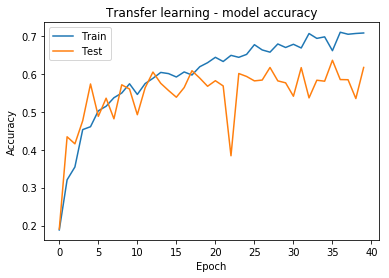

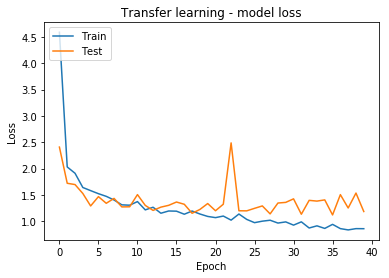

In [16]:
# summarize history for accuracy
plt.plot(history_tl.history['acc'])
plt.plot(history_tl.history['val_acc'])
plt.title('Transfer learning - model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_tl.history['loss'])
plt.plot(history_tl.history['val_loss'])
plt.title('Transfer learning - model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from keras.preprocessing import image
from keras.optimizers import SGD

In [18]:
import PIL as pil

In [19]:
NB_IV3_LAYERS_TO_FREEZE = 172 #freezes everything besides top two inception blocks
def setupFinetuning(model):
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# reload best result after transfer learning
newModel.load_weights('weights-tl-13-0.60.hdf5') 

In [21]:
setupFinetuning(newModel)

In [22]:
filepath="weights-ft-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# start fine tuning
history_ft = newModel.fit_generator(
    train_generator,
    nb_epoch=30,
    steps_per_epoch = 40,
    validation_data=test_generator,
    validation_steps = 40,
    class_weight='auto',callbacks = callbacks_list)

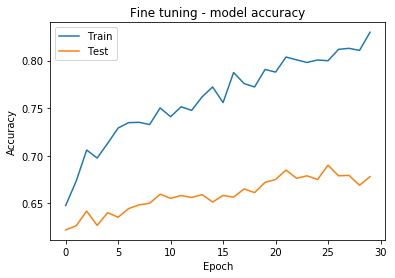

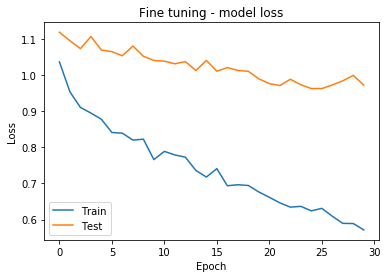

In [24]:
# summarize history for accuracy
plt.plot(history_ft.history['acc'])
plt.plot(history_ft.history['val_acc'])
plt.title('Fine tuning - model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Fine tuning - model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()